In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import string as string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
# uncomment if required
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')
# nltk.download('wordnet')

In [2]:
df = pd.read_csv('fake.csv')

In [3]:
#Create a new column 'post_engagement' which is the sum of the 'likes', 'comments', and 'shares' columns

#sum_list = ['likes', 'comments', 'shares']
#df['post_engagement'] = df[sum_list].sum(axis=1)

In [4]:
#Checking how many null entries in each column

df.isnull().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

In [5]:
#Zooming in on "country" column, "US" is the most common entry

df.country.value_counts()

US    10367
GB      831
RU      400
DE      224
FR      207
TV      201
EU      112
CA      103
IS      100
ES      100
NL       55
ME       34
IN       23
BG       19
CO       17
LI       10
IR        7
EE        4
ZA        3
SG        2
IO        1
SE        1
AU        1
CH        1
Name: country, dtype: int64

In [6]:
#Filling null entries in "country" column with "US" as it is the most common

df.country.fillna("US", inplace=True)

In [7]:
#Remove countries that have less than 20 entries

value_counts = df.country.value_counts()
to_remove = value_counts[value_counts<20].index
df.replace(to_remove, np.nan, inplace = True)

In [8]:
df.language.value_counts()

english       12403
russian         203
spanish         172
german          111
french           38
arabic           22
portuguese       11
turkish          10
italian           9
ignore            7
greek             4
dutch             3
norwegian         3
finnish           1
chinese           1
polish            1
Name: language, dtype: int64

In [9]:
#Remove all non-english entries as there are too few

df = df[df.language == 'english']

In [10]:
#Dropping columns that will not be used

df = df.drop(['uuid', 'language', 'crawled', 'published', 'ord_in_thread', 'domain_rank', 'main_img_url', 'thread_title'], axis = 1)

In [11]:
#Removing rows with missing values

df = df.dropna()

# EDA

Correlation matrix for numerical attributes

Correlation

In [12]:
corrData = pd.DataFrame(df[['spam_score', 'replies_count', 'participants_count', 'likes', 'comments', 'shares']])
corrData.head()

spam_score  replies_count  participants_count  likes  comments  shares
0       0.000              0                   1      0         0       0
1       0.000              0                   1      0         0       0
2       0.000              0                   1      0         0       0
3       0.068              0                   0      0         0       0
4       0.865              0                   0      0         0       0

<AxesSubplot:>

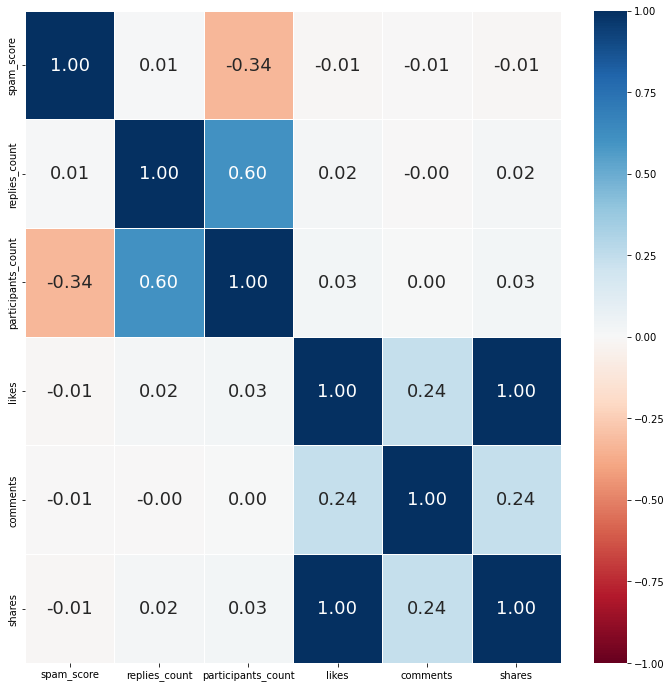

In [13]:
corrData = pd.concat([corrData, df["spam_score"]], axis = 1).reindex(df.index)

#print(df.corr())

f = plt.figure(figsize=(12, 12))

sb.heatmap(df.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

We can see from the plot that the participation count had the strongest negative correlation, meaning that if there were more participants for a given news thread, then that was an indication that it is not a fake news thread.

As for other factors like reply count, likes, comments and shares have a weaker correlation but show that the greater engagement with the particular post would suggest that it would have a lower spam score.

The result from the correlation implies that variables that measure more particpation and/or engagement with a particular post could hint to be the authenticity of the thread and ascertain a spam score.

Spam score frequency

<AxesSubplot:>

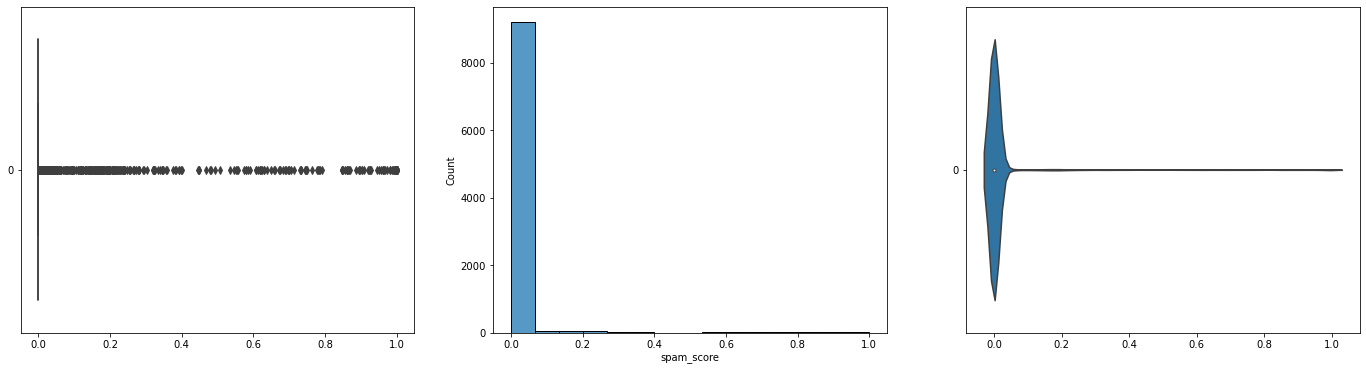

In [14]:
#Too many 0s for spam_score

f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = df.spam_score, orient = "h", ax = axes[0])
sb.histplot(data = df.spam_score, ax = axes[1])
sb.violinplot(data = df.spam_score, orient = "h", ax = axes[2])

In [15]:
#Remove 0 rows in spam_score to eliminate skewness (considering if we should remove the 0s?)

df = df[df.spam_score != 0]
spam = pd.DataFrame(df['spam_score'])

<AxesSubplot:>

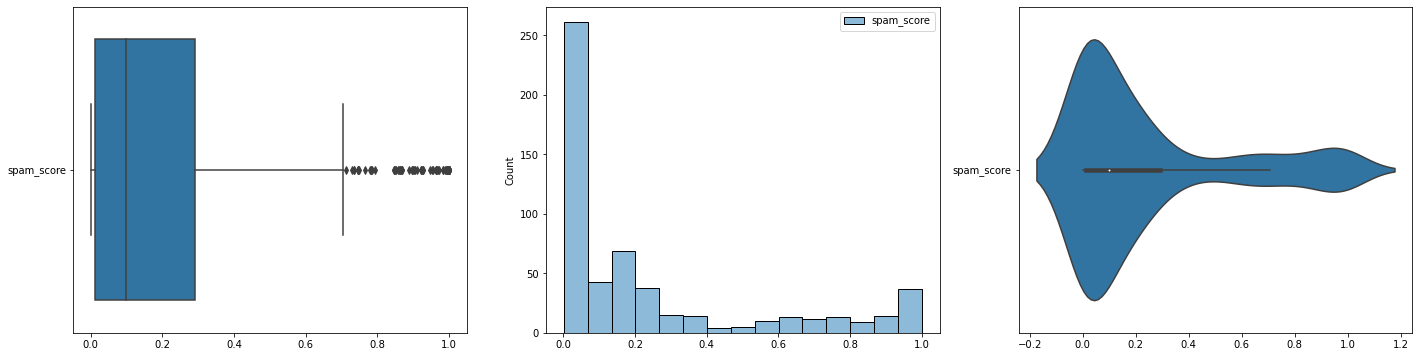

In [16]:
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = spam, orient = "h", ax = axes[0])
sb.histplot(data = spam, ax = axes[1])
sb.violinplot(data = spam, orient = "h", ax = axes[2])

In [17]:
#Converting values of spam_score from numeric to categorical where 
#spam_score <= 0.3 is changed to 'low'
#0.3 < spam_score <= 0.6 is changed to 'medium'
#spam_score > 0.6 is changed to 'high'

df.loc[(df.spam_score <= 0.3) & (df.spam_score > 0), 'spam_score'] = 0.3
df.loc[(df.spam_score > 0.3) & (df.spam_score <= 0.6), 'spam_score'] = 0.6
df.loc[(df.spam_score > 0.6), 'spam_score'] = 1

#df.loc[(df.spam_score == 0), 'spam_score'] = 'zero'
df.loc[(df.spam_score == 0.3), 'spam_score'] = 'low'
df.loc[(df.spam_score == 0.6), 'spam_score'] = 'medium'
df.loc[(df.spam_score == 1), 'spam_score'] = 'high'

df["spam_score"] = df["spam_score"].astype('category')

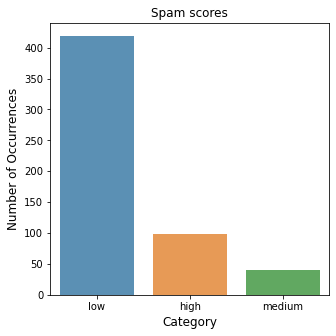

In [18]:
a = df["spam_score"].value_counts()
plt.figure(figsize=(5,5))
sb.barplot(x=a.index, y=a.values, alpha=0.8, order = a.index)
plt.title('Spam scores')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

This visualisation can be used to gauge how many news thread have been assiged a low, medium, or high spam scores

Spam frequency by authors

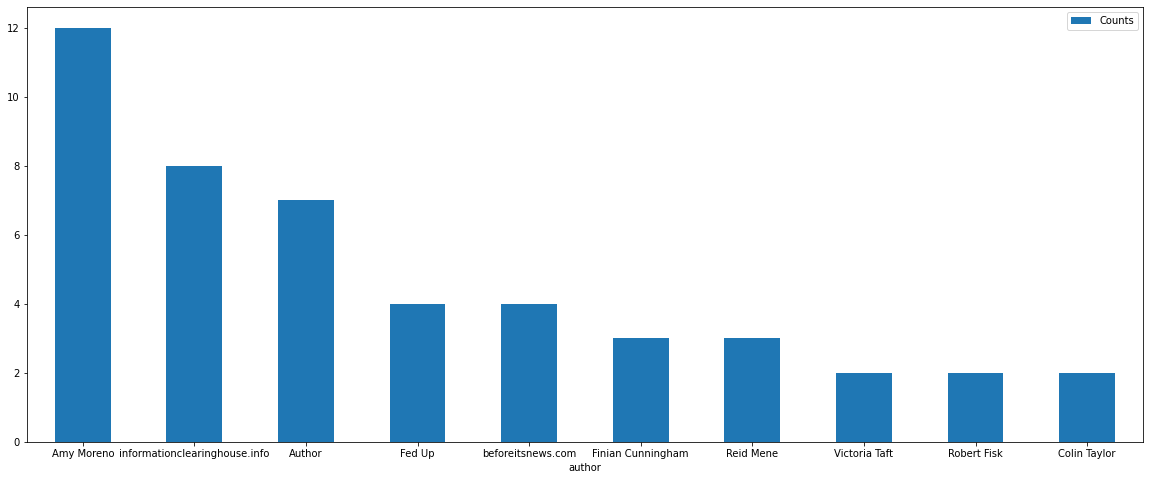

In [19]:
spamHigh = df[df['spam_score']=='high']
s = pd.DataFrame(spamHigh.value_counts('author'))
s = s.head(10)
s = s.reset_index()

ax = s.plot.bar(x='author', y=0, rot=0, figsize=(20,8), label='Counts')

Bar graph for high spam score

The top writer Amy Moreno can also be seen in the low and medium bracket, suggesting it might be the content the writer uploads would have incurred a higher spam score. Other unnamed writers that include “author” can also be seen in both of the brackets i.e high and below.

The one author that sounds out in the higher spam score is the information clearing house where it can’t be seen in the lower bracket for spam score indicates this news source is a potential hub for the spread of misinformation.

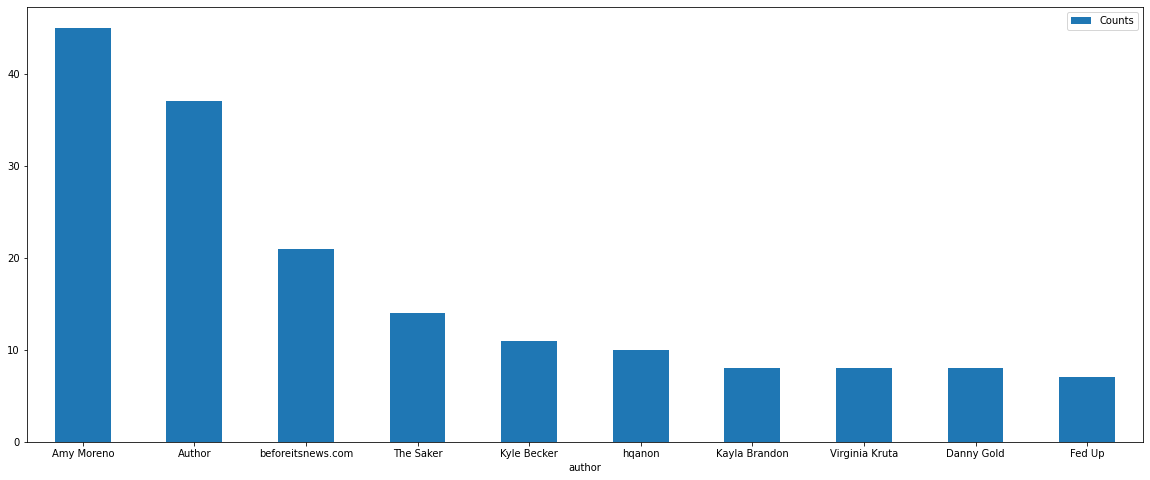

In [20]:
spamNotHigh = df[df['spam_score']!='high']
s = pd.DataFrame(spamNotHigh.value_counts('author'))
s = s.head(10)
s = s.reset_index()

ax = s.plot.bar(x='author', y=0, rot=0, figsize=(20,8), label='Counts')

Bar graph for low and medium spam score

Title effect on spam score

Titles of the threads posted with fake news are meant to lure the user so they click the news title and get directed to the news text. The counts of the top words in the title with high spam score show that it mostly contains buzz words such as “wwiii” (world war three) and a large number of the word “yuge” which was a term associated with Donald Trump for his accent, hints to the nature of the fake news being mostly targeted at politics and current affairs.

In [21]:
#stop_words are the words that we ignore
 
stop_words = stopwords.words("english")

#function to tokenize text and remove stopwords, punctuations, non ascii characters

def stemmer(txt):
    txt=txt.lower()
    words = word_tokenize(txt)
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isascii()]
    return( " ".join(words ))

In [22]:
df["title_stemmed"] = df["title"].apply(stemmer)

In [23]:
txt = df["title_stemmed"].tolist()
vectorizer = TfidfVectorizer()
vectorizer.fit(txt)

# dictionary of all the words in title can use to analyse with bar chart with high spam score
# https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary

mydict = vectorizer.vocabulary_

# to see count of "muslims"
# print("Count of 'muslims' in titles:", mydict["muslims"])

# to get top N most common words
import operator
mydict = dict( sorted(mydict.items(), key=operator.itemgetter(1),reverse=True))

n = 10

for i, (k, v) in enumerate(mydict.items()):
  if i == n: break
  print(k,":", v)

zionist : 2218
zika : 2217
zabivaka : 2216
yuge : 2215
yr : 2214
youtube : 2213
young : 2212
york : 2211
yet : 2210
yesterday : 2209


Country wise frequency

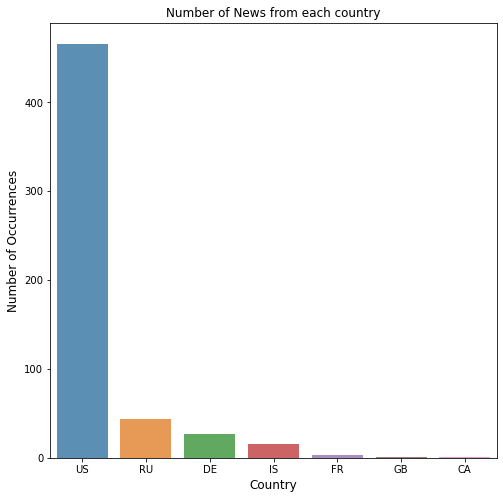

In [24]:
a = df["country"].value_counts()
plt.figure(figsize=(8,8))
sb.barplot(x=a.index, y=a.values, alpha = 0.8)
plt.title('Number of News from each country')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.show()

The graph can be used to gauge how many threads are from which country. This will help us understand which country has the most fake news threads.

The US has the most number by a large margin.

Relationship between Spam scores and the usage of Punctuation marks in the title

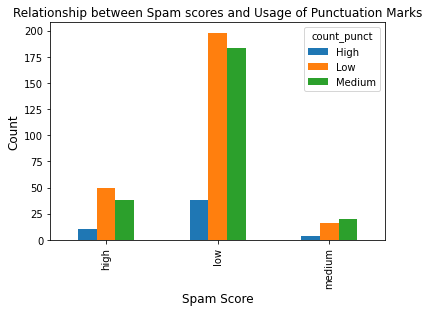

In [25]:
temp_df = pd.DataFrame()
temp_df["title"] = df["title"]
temp_df["spam_score"] = df["spam_score"]
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
temp_df['count_punct'] = df.title.apply(lambda s: count(s, string.punctuation))

temp_df.loc[(temp_df.count_punct <=1), 'count_punct'] = 1
temp_df.loc[(temp_df.count_punct >1) & (temp_df.count_punct <=4), 'count_punct'] = 2
temp_df.loc[(temp_df.count_punct >4), 'count_punct'] = 3

temp_df.loc[(temp_df.count_punct == 1), 'count_punct'] = 'Low'
temp_df.loc[(temp_df.count_punct == 2), 'count_punct'] = 'Medium'
temp_df.loc[(temp_df.count_punct == 3), 'count_punct'] = 'High'
    
temp_df = temp_df.groupby(['spam_score', 'count_punct']).size()
temp_df = temp_df.unstack()
temp_df.plot(kind='bar')

plt.ylabel('Count', fontsize = 12)
plt.xlabel('Spam Score', fontsize = 12)
plt.title('Relationship between Spam scores and Usage of Punctuation Marks')
plt.show()

Spam frequency by URLs

A possible insight could be whichh URLs had the highest number of High spam scores attributed to them.

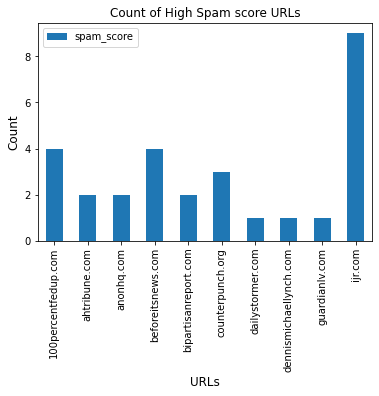

In [26]:
tempURL_df = pd.DataFrame()
tempURL_df["site_url"] = df["site_url"]
tempURL_df["spam_score"] = df["spam_score"]

tempURL_df = tempURL_df[tempURL_df['spam_score'] == 'high']
count_df = tempURL_df.groupby(['site_url']).count()

count_df = pd.DataFrame(count_df).head(10)


count_df.plot(kind='bar')
plt.ylabel('Count', fontsize = 12)
plt.xlabel('URLs', fontsize = 12)
plt.title('Count of High Spam score URLs')
plt.show()

It can be seen that the Website URLs, "anonhq.com" has the highest frequency of High Spam Scores attributed to them, suggesting that either the content put up on these websites or the kind of writers who put up the content, might be such that falls under the category of spam, thereby incurring a high spam score.

Spam frequency by engagement

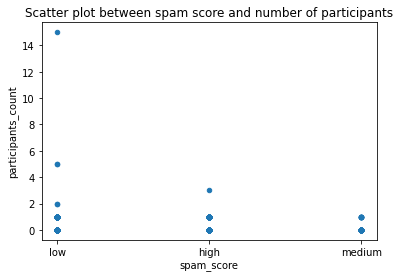

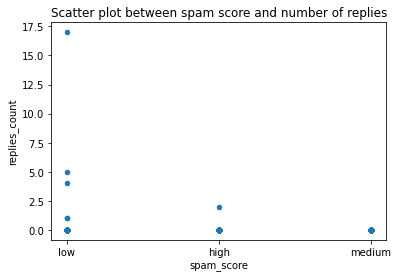

In [27]:
df.plot.scatter(x='spam_score', y='participants_count', title = "Scatter plot between spam score and number of participants")
df.plot.scatter(x='spam_score', y='replies_count', title = "Scatter plot between spam score and number of replies")
plt.show()

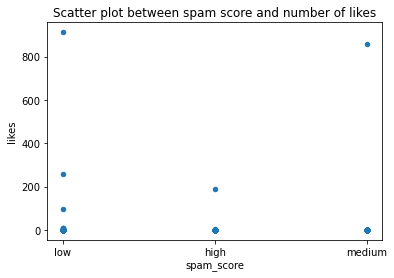

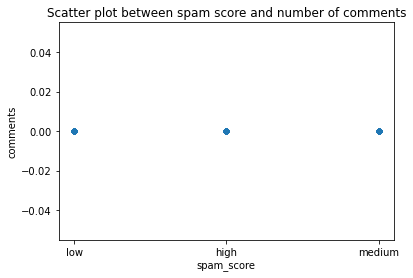

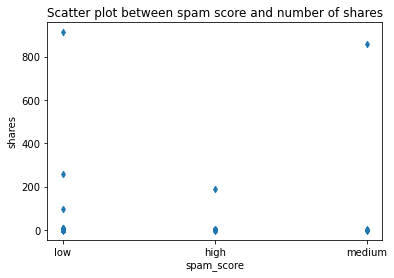

In [28]:
df.plot.scatter(x='spam_score', y='likes', title = "Scatter plot between spam score and number of likes")
df.plot.scatter(x='spam_score', y='comments', title = "Scatter plot between spam score and number of comments")
df.plot.scatter(x='spam_score', y='shares', title = "Scatter plot between spam score and number of shares", marker='d')
plt.show()

The scatter plot of the spam scores against likes, comments, shares and number of replies and participants on the tweet show that engagement via likes, shares, number of replies and number of participants is much lesser for tweets with a high spam score compared to tweets with a low and medium score. Interestingly, the number of comments on tweet from all three categories (low, medium and high) were the same.

## Machine Learning

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from scipy.sparse import hstack

In [189]:
vectorizer = TfidfVectorizer(min_df = 2, ngram_range = (2,3))

In [232]:
# combine title and text, TFIDF matrix

df["text_stemmed"] = df["text"].apply(stemmer)

text_matrix = vectorizer.fit_transform(df["text_stemmed"])
title_matrix = vectorizer.fit_transform(df["title_stemmed"])

dictvector = DictVectorizer()
categorical_matrix = dictvector.fit_transform(df[['author','site_url','country','spam_score']].to_dict('records'))
onehot = OneHotEncoder()
#categorical_matrix = onehot.fit_transform(categorical_matrix.toarray()).toarray()

combined_matrix = hstack([title_matrix, text_matrix, categorical_matrix])

In [233]:
# split into train and test

x_train, x_test, y_train, y_test = train_test_split(combined_matrix, df["spam_score"], test_size = 0.3)

In [234]:
# Machine Learning Model - PassiveAggressiveClassifier (1.0 accuracy wtf?!)

pac = PassiveAggressiveClassifier(max_iter = 50)
pac.fit(x_train, y_train)
y_predict = pac.predict(x_test)
score = accuracy_score(y_test, y_predict)
print(score)

1.0


In [235]:
# Machine Learning Model - Bayes

NB = MultinomialNB()
NB.fit(x_train, y_train)
score = NB.score(x_test, y_test)
print(score)

0.8392857142857143


In [236]:
# Machine Learning Model - K Nearest Neighbor

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
score = knn.score(x_test, y_test)
print(score)

0.9404761904761905


In [ ]:
# todo: confusion matrix for data visualisation